# Reinforcement Learning, Part 5: Continuous States and Actions

So far, our agents have been designed to have a simple memory, entirely made of tables. Most real-world problems, however, require dealing with continuous quantities. Mazes do not come divided in cells, and navigation does not happen in single steps along the four cardinal directions.

To deal with this, we need to make a jump from $V$- and $Q$-tables to approximatig $V$- and $Q$-_functions_.

In [10]:
import random
import math
import numpy as np
from copy import copy
import matplotlib.pyplot as plt 

## A continuous maze

We will now create a continuous environment, a maze that is not made of predefined cells but of a continuous 2D space, bounded in both axes in the range (0, 1).

The reward (the cheese) is placed in a specific position, (0.75, 0.75). The reward is obtained whenever the agent falls within a distance of < 0.1 from that point. 

In [131]:
def distance(v1, v2):
    """2D Euclidean distance"""
    if v1 is None or v2 is None:
        return 0.0
    else:
        x1, y1 = v1
        x2, y2 = v2
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


Now

In [132]:
class Maze():
    """A maze environment"""

    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    CHEESE_POS = (0.75, 0.75)
    CHEESE_RAD = 0.1
    
    def is_reward(self, state):
        """Determins if we are close enough to the cheese"""
        a = np.array(state)
        b = np.array(Maze.CHEESE_POS)
        if math.sqrt(np.sum((a-b)**2)) < Maze.CHEESE_RAD:
            return True
        else:
            return False
        
        
    def reward(self, state):
        if state is None:
            return 0
        elif self.is_reward(state):
            return 10
        else:
            return 0
        
        
    def __init__(self):
        """Inits a maze by loading the grid file"""
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state given the current action"
        # If we have reached the cheese, we transition 
        # to the terminal state
        if self.is_reward(state1):
            return None
        
        x1, y1 = state1
        dx, dy = action1
        
        x2 = min(max(0, x1 + dx), 1)
        y2 = min(max(0, y1 + dy), 1)
                            
        return (x2, y2)
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        #if state1 == state2:
        #    return -1
        if state2 == None:
            return 0
        else:
            if self.is_reward(state2):
                return 10
            else:
                return 0
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1
    

## State aggregation 
The easiest method to handle continuous states is called _state aggregation_, and is basically a discretization of the continuous space.
Now, the agent

In [133]:
    
class ContinuousTDAgent():
    """An agent that keeps track of the value of states"""
    def __init__(self, alpha=0.1, gamma=0.9, step=0.1, res=10):
        """Creates a V-agent"""
        self.step = step
        #self.W = [0.0 for x in CENTERS]
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.values = np.zeros((res, res))
        self.res = res
        
    def policy(self, state):
        """Random policy to explore the maze"""
        angle = random.uniform(0, math.pi * 2)
        s = self.step
        return (math.sin(angle) * s, math.cos(angle) * s)
        
    
    def td_learning(self, state1, reward1, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha

        x1, y1 = state1
        n = self.res - 1
        vx1 = min(math.floor(self.res * x1), n)
        vy1 = min(math.floor(self.res * y1), n)
        
        v1 = self.values[vx1, vy1]
        
        v2 = 0
        
        if state2 is not None:
            x2, y2 = state2
            vx2 = min(math.floor(self.res * x2), n)
            vy2 = min(math.floor(self.res * y2), n)
        
            v2 = self.values[vx2, vy2]
                
        rpe = reward1 + g * v2 - v1
        self.values[vx1, vy1] += a * rpe

    
def plot_v_table(agent, ax=None, title=r"$V$-table", **kwargs):
    "Plots a matrix-like representation of the V-table of an agent"
    if not ax:
        ax = plt.gca()

    data = np.zeros((4,4))            
            
    for s in agent.V.keys():
        x, y = s
        data[x, y] = agent.V[s]
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs, cmap="viridis")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(range(1,5))
    ax.set_yticklabels(range(1,5))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    return im

In [113]:
def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    reward1 = environment.reward(state1)
    state2 = "Start"
    
    history = []
    
    while state2 != None:
        action = agent.policy(state1)
        state2, reward2 = environment.transition(action)
        history.append(state2)
        # Update the V-values for state1
        agent.td_learning(state1, reward1, state2)
        
        state1 = state2
        reward1 = reward2

    return history

    
def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = rl_loop(environment, agent)
        history.append(h)
        environment.state = Maze.INITIAL_STATE
    
    return history    

    

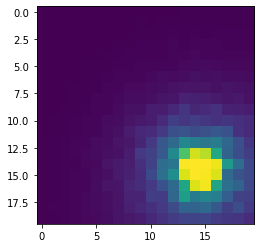

In [129]:
m = Maze()
a = ContinuousTDAgent(alpha=0.1, res=20)

# Because the agent moves at random, the following instruction can take a variable amount of time to complete
h=run_trials(m, a, 1000)
a.values
plt.imshow(a.values)

In [ ]:
print(t[1])
xs = [j[0] for j in h[:-1]]
ys = [j[1] for j in h[:-1]]
plt.plot(xs, ys)